# Molecular Exploratory Analysis of MAO-A ligand data set

In this notebook, the analysis of the data set obtained from CheMBL of molecules that binds MAO-A will be ilustrated, it includes:

1. Data set cleaning using Pandas
2. Structural exploratory analysis with RDkit, datamol and mols2grid
3. Data preparation (Clustering) for future ML/DL techniques

In [1]:
#Essentials for data handle
import os
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(color_codes=True)
import matplotlib.pyplot as plt

#Chemistry data handle
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import rdBase
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors as rdmd
from rdkit.Chem import Descriptors

#Other tools
import datamol as dm
import mols2grid

In [2]:
#Special Settings for number format
rdDepictor.SetPreferCoordGen(True)
pd.options.display.float_format = '{:,.2f}'.format

## Loading Data set and data Cleaning

In [3]:
#loading CSV file and first look at the data
Original_MAO_df = pd.read_csv('MAO-A_dataset_CheMBL.csv', sep=';')
Original_MAO_df.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type
0,CHEMBL248049,NaN,NaN,319.86,1.00,5.44,20,CC1CCC(=NNc2nc(-c3ccc(Cl)cc3)cs2)CC1,IC50,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1250430,1,Scientific Literature,Bioorg Med Chem,"2,010.00",CHEMBL3833782,NaN,NaN
1,CHEMBL589765,NaN,NaN,314.35,0.00,0.86,5f,Cc1cccc(COc2nc3c(c(=O)n(C)c(=O)n3C)n2C)c1,IC50,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1156881,1,Scientific Literature,Bioorg Med Chem,"2,010.00",NaN,NaN,NaN
2,CHEMBL86304,MOCLOBEMIDE,4.00,268.74,0.00,1.40,moclobemide,O=C(NCCN1CCOCC1)c1ccc(Cl)cc1,Inhibition,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1250430,1,Scientific Literature,Bioorg Med Chem,"2,010.00",CHEMBL3833782,NaN,NaN
3,CHEMBL600384,NaN,NaN,252.31,0.00,4.01,(S)(+)2k,Cc1ccc([C@@H]2CC(=O)c3ccc(C)cc3O2)cc1,Inhibition,NaN,...,Homo sapiens,SINGLE PROTEIN,CHEMBL1159098,1,Scientific Literature,Bioorg Med Chem,"2,010.00",CHEMBL3833782,NaN,NaN
4,CHEMBL597716,NaN,NaN,282.36,1.00,5.15,4o,COc1ccc2c(=S)cc(-c3ccc(C)cc3)oc2c1,Inhibition,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1159098,1,Scientific Literature,Bioorg Med Chem,"2,010.00",CHEMBL3833782,NaN,NaN


In [4]:
#Selecting the columns (metadata) needed for the analysis
Original_MAO_df.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties',
       'Action Type'],
      dtype='object')

In [5]:
MAO_df = Original_MAO_df[['Molecule ChEMBL ID', 'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units']]

#Making copy to not have issues with overwriting dataframe
MAO_df1 = MAO_df.copy()

#To avoid problem with mols2grid, it is recomended to convert Smiles -> SMILES
MAO_df1.rename(columns={'Smiles': 'SMILES'}, inplace=True)
MAO_df1.head()

,Molecule ChEMBL ID,SMILES,Standard Type,Standard Relation,Standard Value,Standard Units
0,CHEMBL248049,CC1CCC(=NNc2nc(-c3ccc(Cl)cc3)cs2)CC1,IC50,'=',"15,135.61",nM
1,CHEMBL589765,Cc1cccc(COc2nc3c(c(=O)n(C)c(=O)n3C)n2C)c1,IC50,'=',546.00,nM
2,CHEMBL86304,O=C(NCCN1CCOCC1)c1ccc(Cl)cc1,Inhibition,'=',86.75,%
3,CHEMBL600384,Cc1ccc([C@@H]2CC(=O)c3ccc(C)cc3O2)cc1,Inhibition,NaN,NaN,%
4,CHEMBL597716,COc1ccc2c(=S)cc(-c3ccc(C)cc3)oc2c1,Inhibition,'=',40.00,%


In [6]:
#droping NA
MAO_df1= MAO_df1.dropna()

In [7]:
#Looking for duplicate entries
MAO_df1['Molecule ChEMBL ID'].value_counts()

Molecule ChEMBL ID
CHEMBL8706       138
CHEMBL92401       78
CHEMBL972         77
CHEMBL86304       66
CHEMBL887         47
                ... 
CHEMBL239508       1
CHEMBL4170390      1
CHEMBL2206103      1
CHEMBL3218126      1
CHEMBL5220267      1
Name: count, Length: 4839, dtype: int64

In [8]:
#Looking for kind of activity measurements available in the data set

MAO_df1['Standard Type'].value_counts()

Standard Type
IC50               4010
Inhibition         1303
Ki                  635
Activity            142
Km                   65
TN                   31
Ratio                19
k cat/Km             18
k cat                18
K inact              12
Kinact               11
KiA                  11
Vmax                 10
Vmax / Km             5
% of inhibition       2
Ri                    1
EC50                  1
Name: count, dtype: int64

In [9]:
#Units of the activity measurements
MAO_df1['Standard Units'].value_counts()

Standard Units
nM             4693
%              1446
min-1            30
mM-1 min-1       23
uM               18
uM min-1         17
M min-1 M-1      14
/M/s             12
ug.mL-1          10
nmol/min          9
10^3nM            8
/min              5
M-1 min-1         4
/min/microM       3
nmol/min/mg       1
µM                1
Name: count, dtype: int64

In [10]:
#To not mix the kind of measurements and units I chosed to keep IC50 in nM. Then inhibitor potency will be analysed.

MAO_df2=MAO_df1[MAO_df1['Standard Units'].str.contains('nM')]
MAO_df2=MAO_df1[MAO_df1['Standard Type'].str.contains('IC50')]

#Sorting all the values to then keep the lowest IC50 values
MAO_df2 = MAO_df2.sort_values('Standard Value', ascending=True)
MAO_df2 = MAO_df2.drop_duplicates('Molecule ChEMBL ID', keep='first')


In [11]:
#Lastly, it is necessary to drop the SMILES structures that contain 2 or more molecules eg. salts, isomers that come together or in complex with molecules such as oxalic acid. They can be found with the pattern "."

#Creating a separate dataframe for the not desirable entries
NotDesired_df = MAO_df2.copy()
NotDesired_df = NotDesired_df[NotDesired_df['SMILES'].str.contains(r'\.', na=False)]
NotDesired_df.shape

(233, 6)

In [12]:
NotDesired_df.head()

,Molecule ChEMBL ID,SMILES,Standard Type,Standard Relation,Standard Value,Standard Units
3675,CHEMBL3415804,C#CCN(C)CC(=C)c1ccoc1.O=C(O)C(=O)O,IC50,'=',0.72,nM
3078,CHEMBL3415795,C#CCN(C)CC(=C)c1ccc(Br)cc1.Cl,IC50,'=',0.85,nM
3542,CHEMBL3415817,C#CCN(C)CC(=C)c1ccc(Cl)c(Cl)c1.O=C(O)C(=O)O,IC50,'=',1.00,nM
3706,CHEMBL3415783,C#CCN(C)CC(=C)c1cccc(COc2ccc(F)cc2)c1.O=C(O)C(...,IC50,'=',1.40,nM
5562,CHEMBL3415611,C#CCNCC(=C)c1cccc(OCc2cccc(F)c2)c1.O=C(O)C(=O)O,IC50,'=',1.90,nM


In [13]:
#Creating visualization to look how not desired structures looks like
mols2grid.display(NotDesired_df, subset=['Molecule ChEMBL ID'])

MolGridWidget()

In [14]:
#With the indexes, those molecules will be droped from the main dataframe
NotDesired_indexes = list(NotDesired_df.index.values)
MAO_df2.drop(index=NotDesired_indexes, inplace = True)

In [15]:
MAO_df2.shape

(3158, 6)

In [16]:
MAO_df2.head()

,Molecule ChEMBL ID,SMILES,Standard Type,Standard Relation,Standard Value,Standard Units
4685,CHEMBL8706,C#CCN(C)CCCOc1ccc(Cl)cc1Cl,IC50,'=',0.00,nM
8626,CHEMBL5200566,C#CCN(C)CCCOc1cc(NC(=O)CCCCCCCCC(=O)NO)ccc1Cl,IC50,'<',0.10,nM
5385,CHEMBL209413,COc1ccc2c(c1)-c1nnc(-c3cccc(C(F)(F)F)c3)cc1C2=O,IC50,'=',0.10,nM
8873,CHEMBL1929421,C#CCN(C)Cc1cc2cc(OCCCC3CCN(Cc4ccccc4)CC3)ccc2n1C,IC50,'=',0.27,nM
879,CHEMBL3319256,Cn1ncc2cc(C(=O)Nc3ccc(Cl)c(Cl)c3)ccc21,IC50,'=',0.39,nM


In [17]:
MAO_df2.tail()

,Molecule ChEMBL ID,SMILES,Standard Type,Standard Relation,Standard Value,Standard Units
4093,CHEMBL2334496,CC(C)(C)OC(=O)N1CCN(C(=S)SCc2cn(Cc3cc(=O)oc4cc...,IC50,'>',"1,250,000.00",nM
3165,CHEMBL3415352,C#CCSc1nc(NNC(N)=S)c(C#N)c(-c2cc(OC)c(OC)c(OC)...,IC50,'>',"1,250,000.00",nM
8033,CHEMBL4868945,O=C(Nc1ccc(Cl)c(Cl)c1)c1c[nH]c2ccccc2c1=O,IC50,'=',"1,743,000.00",nM
7640,CHEMBL4865248,Cn1cc(C(=O)Nc2cccc(Cl)c2)c(=O)c2ccccc21,IC50,'=',"7,482,000.00",nM
9486,CHEMBL5191876,O=S(=O)(N1CCc2cc(C3CC3NCC3CCNCC3)ccc21)C(F)(F)F,IC50,'=',"8,637,000.00",nM


In [18]:
Original_MAO_df.shape

(9595, 46)

In [19]:
MAO_df2.shape

(3158, 6)

 - Original data set was reduced from 9595 to 3158 molecules entries.

In [20]:
# Creating new Data frame to work with and set new indexes

MAO_df_clean = MAO_df2.copy()
MAO_df_clean= MAO_df_clean.reset_index(drop=True)
MAO_df_clean.shape

(3158, 6)

In [21]:
#Adding molecule objects to data frame

MAO_df_clean['mol'] = dm.from_df(MAO_df_clean, smiles_column='SMILES')
MAO_df_clean.head()

,Molecule ChEMBL ID,SMILES,Standard Type,Standard Relation,Standard Value,Standard Units,mol
0,CHEMBL8706,C#CCN(C)CCCOc1ccc(Cl)cc1Cl,IC50,'=',0.00,nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2c89f89e0>
1,CHEMBL5200566,C#CCN(C)CCCOc1cc(NC(=O)CCCCCCCCC(=O)NO)ccc1Cl,IC50,'<',0.10,nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2c89f8a50>
2,CHEMBL209413,COc1ccc2c(c1)-c1nnc(-c3cccc(C(F)(F)F)c3)cc1C2=O,IC50,'=',0.10,nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2c89f8ac0>
3,CHEMBL1929421,C#CCN(C)Cc1cc2cc(OCCCC3CCN(Cc4ccccc4)CC3)ccc2n1C,IC50,'=',0.27,nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2c89f8b30>
4,CHEMBL3319256,Cn1ncc2cc(C(=O)Nc3ccc(Cl)c(Cl)c3)ccc21,IC50,'=',0.39,nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2c89f8ba0>


In [22]:
MAO_df_clean.shape

(3158, 7)

## Calculating 1D descriptors

In [23]:
def max_ring_size(mol):
    """Get the size of the largest ring in a molecule

    - mol: input_molecule
    - return: size of the largest ring or 0 for an acyclic molecule

    """
    
    ri = mol.GetRingInfo()
    atom_rings = ri.AtomRings()
    if len(atom_rings) == 0:
        return 0
    else:
        return max([len(x) for x in ri.AtomRings()])

In [24]:
MAO_prop_dict = {
    "Mw" : dm.descriptors.mw,
    "logP" : dm.descriptors.clogp,
    "HBd" : dm.descriptors.n_lipinski_hbd,
    "HBa" : dm.descriptors.n_lipinski_hba,
    "Max_ring_size" : max_ring_size
}

In [25]:
MAO_prop_df = dm.descriptors.batch_compute_many_descriptors(MAO_df_clean.mol, properties_fn=MAO_prop_dict ,add_properties=False, progress=True)

  0%|          | 0/3158 [00:00<?, ?it/s]

In [26]:
MAO_prop_df.head()

,Mw,logP,HBd,HBa,Max_ring_size
0,271.05,3.33,0,2,6
1,451.22,4.24,3,7,6
2,356.08,4.38,0,4,6
3,443.29,5.31,0,4,6
4,319.03,4.13,1,4,6


In [27]:
MAO_prop_df.shape

(3158, 5)

In [28]:
#Concatenate clean data frame and new dataframe with properties

MAO_prop_clean_df = pd.concat([MAO_df_clean,MAO_prop_df],axis=1)
MAO_prop_clean_df.shape

(3158, 12)

In [29]:
MAO_prop_clean_df.head()

,Molecule ChEMBL ID,SMILES,Standard Type,Standard Relation,Standard Value,Standard Units,mol,Mw,logP,HBd,HBa,Max_ring_size
0,CHEMBL8706,C#CCN(C)CCCOc1ccc(Cl)cc1Cl,IC50,'=',0.00,nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2c89f89e0>,271.05,3.33,0,2,6
1,CHEMBL5200566,C#CCN(C)CCCOc1cc(NC(=O)CCCCCCCCC(=O)NO)ccc1Cl,IC50,'<',0.10,nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2c89f8a50>,451.22,4.24,3,7,6
2,CHEMBL209413,COc1ccc2c(c1)-c1nnc(-c3cccc(C(F)(F)F)c3)cc1C2=O,IC50,'=',0.10,nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2c89f8ac0>,356.08,4.38,0,4,6
3,CHEMBL1929421,C#CCN(C)Cc1cc2cc(OCCCC3CCN(Cc4ccccc4)CC3)ccc2n1C,IC50,'=',0.27,nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2c89f8b30>,443.29,5.31,0,4,6
4,CHEMBL3319256,Cn1ncc2cc(C(=O)Nc3ccc(Cl)c(Cl)c3)ccc21,IC50,'=',0.39,nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2c89f8ba0>,319.03,4.13,1,4,6


## Filtering according descriptors

The data frame is filtered according to the Lipinski Rule of 5 (Ro5) and how many Ro5 will be counted and included in the data frame

In [30]:
MAO_prop_clean_df['ro5_ok'] = (MAO_prop_clean_df.Mw <= 500) & (MAO_prop_clean_df.logP <=5) & (MAO_prop_clean_df.HBd <= 5) & (MAO_prop_clean_df.HBa <= 10)
MAO_prop_clean_df.ro5_ok.sum()


def bool_to_int(bool_in):
    return bool_in.values.astype(int)

MAO_prop_clean_df['ro5_count'] = bool_to_int(MAO_prop_clean_df.Mw <= 500) + bool_to_int(MAO_prop_clean_df.logP <=5) + bool_to_int(MAO_prop_clean_df.HBd <= 5) + bool_to_int(MAO_prop_clean_df.HBa <= 10)

len(MAO_prop_clean_df.query("ro5_count == 4"))

2657

In [31]:
MAO_prop_clean_df.head()

,Molecule ChEMBL ID,SMILES,Standard Type,Standard Relation,Standard Value,Standard Units,mol,Mw,logP,HBd,HBa,Max_ring_size,ro5_ok,ro5_count
0,CHEMBL8706,C#CCN(C)CCCOc1ccc(Cl)cc1Cl,IC50,'=',0.00,nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2c89f89e0>,271.05,3.33,0,2,6,True,4
1,CHEMBL5200566,C#CCN(C)CCCOc1cc(NC(=O)CCCCCCCCC(=O)NO)ccc1Cl,IC50,'<',0.10,nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2c89f8a50>,451.22,4.24,3,7,6,True,4
2,CHEMBL209413,COc1ccc2c(c1)-c1nnc(-c3cccc(C(F)(F)F)c3)cc1C2=O,IC50,'=',0.10,nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2c89f8ac0>,356.08,4.38,0,4,6,True,4
3,CHEMBL1929421,C#CCN(C)Cc1cc2cc(OCCCC3CCN(Cc4ccccc4)CC3)ccc2n1C,IC50,'=',0.27,nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2c89f8b30>,443.29,5.31,0,4,6,False,3
4,CHEMBL3319256,Cn1ncc2cc(C(=O)Nc3ccc(Cl)c(Cl)c3)ccc21,IC50,'=',0.39,nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2c89f8ba0>,319.03,4.13,1,4,6,True,4


In [32]:
#A quick check of the data types to know how to plot the calculated descriptors
MAO_prop_clean_df.select_dtypes(include='object').nunique()

Molecule ChEMBL ID    3158
SMILES                3158
Standard Type            1
Standard Relation        4
Standard Units           3
mol                   3158
dtype: int64

In [33]:
MAO_prop_clean_df.dtypes

Molecule ChEMBL ID     object
SMILES                 object
Standard Type          object
Standard Relation      object
Standard Value        float64
Standard Units         object
mol                    object
Mw                    float64
logP                  float64
HBd                     int64
HBa                     int64
Max_ring_size           int64
ro5_ok                   bool
ro5_count               int64
dtype: object

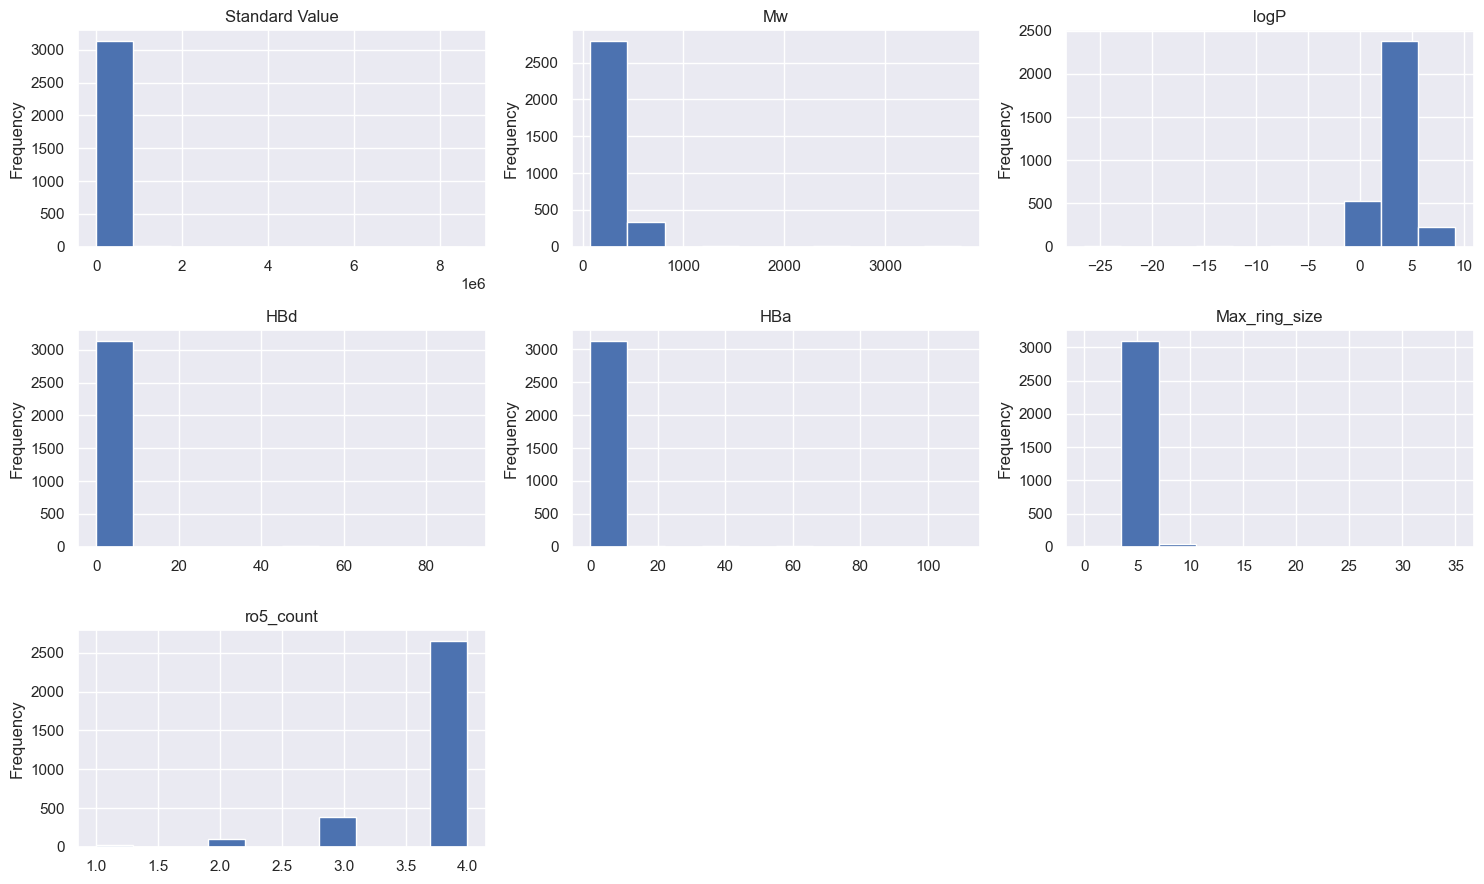

In [34]:
#Ploting the descriptors in grid
IntFloat_vars = MAO_prop_clean_df.select_dtypes(include='float').columns.tolist() + MAO_prop_clean_df.select_dtypes(include='int').columns.tolist()


num_cols = len(IntFloat_vars)
num_rows = (num_cols +2)//3

fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 3*num_rows))
axs = axs.flatten()

for i, var in enumerate(IntFloat_vars):
    MAO_prop_clean_df[var].plot.hist(ax=axs[i])
    axs[i].set_title(var)


if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

fig.tight_layout()

plt.show()


## Clustering

Since MAO-A is able to degradate different kinds of monoamines, their substrates and inhibitors present a wide collection of different backbone structures. Clustering them we can observe at first instance how different they are. For that, the Tylor-Butina clustering method is used.



In [35]:
def ButinaCluster(mol_list, cutoff=0.35):
    fp_list = [rdmd.GetMorganFingerprintAsBitVect(m, 3, nBits=2048) for m in mol_list]
    dists = []
    nfps = len(fp_list)

    for i in range(1, nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        dists.extend([1-x for x in sims])

    mol_clusters = Butina.ClusterData(dists, nfps, cutoff, isDistData=True)
    cluster_id_list = [0]*nfps

    for idx, cluster in enumerate(mol_clusters, 1):
        for member in cluster:
            cluster_id_list[member] = idx

    return cluster_id_list
     

In [36]:
#Creating specific clustering dataframe and apply ButinaCluster function. The cluster ID is added to the dataframe
MAO_cluster_df = MAO_prop_clean_df.copy()
%time MAO_cluster_df['Cluster'] = ButinaCluster(MAO_cluster_df.mol.values)


CPU times: user 1.47 s, sys: 59.2 ms, total: 1.53 s
Wall time: 1.54 s


In [37]:
#Visualizing Clustering result and attaching corresponding ChEMBL ID, Cluster, and Ro5
mols2grid.display(MAO_cluster_df, subset=['Molecule ChEMBL ID', 'Cluster', 'ro5_count'])

MolGridWidget()

In [38]:
MAO_cluster_df.head()

,Molecule ChEMBL ID,SMILES,Standard Type,Standard Relation,Standard Value,Standard Units,mol,Mw,logP,HBd,HBa,Max_ring_size,ro5_ok,ro5_count,Cluster
0,CHEMBL8706,C#CCN(C)CCCOc1ccc(Cl)cc1Cl,IC50,'=',0.00,nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2c89f89e0>,271.05,3.33,0,2,6,True,4,1605
1,CHEMBL5200566,C#CCN(C)CCCOc1cc(NC(=O)CCCCCCCCC(=O)NO)ccc1Cl,IC50,'<',0.10,nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2c89f8a50>,451.22,4.24,3,7,6,True,4,238
2,CHEMBL209413,COc1ccc2c(c1)-c1nnc(-c3cccc(C(F)(F)F)c3)cc1C2=O,IC50,'=',0.10,nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2c89f8ac0>,356.08,4.38,0,4,6,True,4,611
3,CHEMBL1929421,C#CCN(C)Cc1cc2cc(OCCCC3CCN(Cc4ccccc4)CC3)ccc2n1C,IC50,'=',0.27,nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2c89f8b30>,443.29,5.31,0,4,6,False,3,54
4,CHEMBL3319256,Cn1ncc2cc(C(=O)Nc3ccc(Cl)c(Cl)c3)ccc21,IC50,'=',0.39,nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2c89f8ba0>,319.03,4.13,1,4,6,True,4,331


In [39]:
# Clusters are sorted according logP and visualized
MAO_cluster_df.sort_values(['Cluster', 'logP'], inplace=True)

mols2grid.display(MAO_cluster_df, subset=['Molecule ChEMBL ID', 'Cluster','logP' ,'ro5_count'], transform={'logP': lambda x: f'{x: .2f}'})

MolGridWidget()

In [40]:
#New data frame is created with the lowest LogP molecule of each cluster

MAO_cluster_unique = MAO_cluster_df.drop_duplicates('Cluster')
mols2grid.display(MAO_cluster_unique, subset=['Molecule ChEMBL ID', 'Cluster','logP' ,'ro5_count'], transform={'logP': lambda x: f'{x: .2f}'})

MolGridWidget()

In [41]:
MAO_cluster_unique.head()

,Molecule ChEMBL ID,SMILES,Standard Type,Standard Relation,Standard Value,Standard Units,mol,Mw,logP,HBd,HBa,Max_ring_size,ro5_ok,ro5_count,Cluster
2976,CHEMBL3660741,CS(=O)(=O)Nc1ccc(-c2coc3cc(C#CC4CN(C(=O)CO)C4)...,IC50,'>',"130,000.00",nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2a8f5ab90>,452.10,1.63,2,8,6,True,4,1
1002,CHEMBL508324,C[C@@H]1CCCC/C1=N/Nc1nc(-c2ccc(C#N)cc2)cs1,IC50,'=',"5,495.41",nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2a8f18430>,310.13,4.66,1,4,6,True,4,2
387,CHEMBL399572,N#Cc1ccc(-c2csc(NN=C3CCCC3)n2)cc1,IC50,'=',644.00,nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2c8a07450>,282.09,4.02,1,4,6,True,4,3
853,CHEMBL3818992,O=C(/C=C/c1ccc(O)c(O)c1)NCCC1CCN(Cc2ccccc2)CC1,IC50,'=',"3,500.00",nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2c8a18270>,380.21,3.53,3,5,6,True,4,4
2093,CHEMBL3629466,COc1ccc(/C=C/c2cc(OC)cc(OC)c2/C=C/C(=O)c2cc3cc...,IC50,'=',"41,700.00",nM,<rdkit.Chem.rdchem.Mol object at 0x7fd2a8f3e5e0>,468.16,5.89,0,6,6,False,3,5


In [42]:
MAO_cluster_unique.shape

(1605, 15)

In [43]:
MAO_cluster_df.shape

(3158, 15)

In [44]:
MAO_cluster_df.columns

Index(['Molecule ChEMBL ID', 'SMILES', 'Standard Type', 'Standard Relation',
       'Standard Value', 'Standard Units', 'mol', 'Mw', 'logP', 'HBd', 'HBa',
       'Max_ring_size', 'ro5_ok', 'ro5_count', 'Cluster'],
      dtype='object')

In [45]:
#Saving MAO_cluster_df and MAO_cluster_unique for posteriori ML/DL training (not including RDkit objects).

MAO_cluster_df_final = MAO_cluster_df[['Molecule ChEMBL ID', 'SMILES', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units', 'Mw', 'logP', 'HBd', 'HBa',
       'Max_ring_size', 'ro5_ok', 'ro5_count', 'Cluster']]
MAO_cluster_unique_final = MAO_cluster_unique[['Molecule ChEMBL ID', 'SMILES', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units', 'Mw', 'logP', 'HBd', 'HBa','Max_ring_size', 'ro5_ok', 'ro5_count', 'Cluster']]

MAO_cluster_df_final.to_csv('MAO-A_cluster.csv', index=None)
MAO_cluster_unique_final.to_csv('MAO-A_cluster_unique.csv', index=None)